In [1]:
!pip install numpy pandas matplotlib tqdm

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
# ONLY FOR COLAB
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory (main project directory in Google Drive)
BASE_DIR = "/content/drive/My Drive/Energy_prediction"

# Check if the path is correct
print(f"Base directory set to: {BASE_DIR}")

Mounted at /content/drive
Base directory set to: /content/drive/My Drive/Energy_prediction


In [4]:
#local
BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..",".."))

In [5]:
# Set path to the data file
data_path = os.path.join(BASE_DIR, "data", "processed", "energy_consumption_aggregated_cleaned_proto.csv")

print("Data path:", data_path)  # Check if the path is correct

Data path: C:\Users\Anwender\Desktop\Projects\Energy_prediction\data\processed\energy_consumption_aggregated_cleaned_proto.csv


In [70]:
df = pd.read_csv(data_path)
df1 = df #store for date column for plots
df.head(-1)

,date,consumption_kWh,hour_sin,hour_cos,weekday_sin,weekday_cos,rolling_mean_6h,month_sin,month_cos,temperature_c,consumption_last_week,consumption_yesterday,consumption_last_hour
0,2018-01-10 00:00:00,0.260592,0.000000,1.000000e+00,0.974928,-0.222521,0.263719,0.500000,0.866025,4.440892e-16,0.229926,0.286202,0.259510
1,2018-01-10 01:00:00,0.261122,0.258819,9.659258e-01,0.974928,-0.222521,0.261654,0.500000,0.866025,-1.035534e+00,0.230674,0.287464,0.260592
2,2018-01-10 02:00:00,0.264432,0.500000,8.660254e-01,0.974928,-0.222521,0.260454,0.500000,0.866025,-1.830127e+00,0.235226,0.293796,0.261122
3,2018-01-10 03:00:00,0.269017,0.707107,7.071068e-01,0.974928,-0.222521,0.261641,0.500000,0.866025,-2.329629e+00,0.240541,0.296367,0.264432
4,2018-01-10 04:00:00,0.284799,0.866025,5.000000e-01,0.974928,-0.222521,0.266579,0.500000,0.866025,-2.500000e+00,0.255311,0.308767,0.269017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18737,2020-02-29 17:00:00,0.249959,-0.965926,-2.588190e-01,-0.974928,-0.222521,0.260044,0.866025,0.500000,8.529629e+00,0.236645,0.213160,0.256942
18738,2020-02-29 18:00:00,0.232648,-1.000000,-1.836970e-16,-0.974928,-0.222521,0.253737,0.866025,0.500000,8.030127e+00,0.234790,0.205155,0.249959
18739,2020-02-29 19:00:00,0.220534,-0.965926,2.588190e-01,-0.974928,-0.222521,0.246251,0.866025,0.500000,7.235534e+00,0.229802,0.201054,0.232648
18740,2020-02-29 20:00:00,0.210280,-0.866025,5.000000e-01,-0.974928,-0.222521,0.238139,0.866025,0.500000,6.200000e+00,0.231792,0.199060,0.220534


In [6]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Entferne die Spalte "date", weil wir schon Zeitfeatures haben
df = df.drop(columns=["date"])

# Features und Target definieren --> entferne is_weekend, kein impact
features = ["hour_sin", "hour_cos", "weekday_sin",	"weekday_cos",	"rolling_mean_6h",	"month_sin",	"month_cos",	"temperature_c",	"consumption_last_week",	"consumption_yesterday",	"consumption_last_hour"]
target = "consumption_kWh"

# Zeitbasierter Train-Valid-Test-Split (70% Train, 10% Valid, 20% Test)
train_size = int(len(df) * 0.7)  # 70% für Training
valid_size = int(len(df) * 0.1)  # 10% für Validierung
test_size = len(df) - train_size - valid_size  # 20% für Test

df_train = df.iloc[:train_size]
df_valid = df.iloc[train_size:train_size + valid_size]
df_test = df.iloc[train_size + valid_size:]

X_train, y_train = df_train[features], df_train[target]
X_valid, y_valid = df_valid[features], df_valid[target]
X_test, y_test = df_test[features], df_test[target]

# LightGBM-Datasets erstellen
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  # Validation hinzufügen
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Ausgabe zur Kontrolle
print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_valid.shape}, Testdaten: {X_test.shape}")


Trainingsdaten: (13120, 11), Validierungsdaten: (1874, 11), Testdaten: (3749, 11)


In [7]:
import lightgbm as lgb

# Features (alle Spalten außer der Zielvariable)
X_train_lgb = X_train.copy()
y_train_lgb = y_train.copy()

# LightGBM Dataset erstellen
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)

# Struktur und erste 5 Einträge ausgeben
print("LightGBM Dataset Struktur:")
print(train_data)

# Feature-Namen ausgeben
print("\nFeature-Namen:")
print(train_data.feature_name)

# Erste paar Zeilen der Feature-Matrix
print("\nErste 5 Einträge im Dataset:")
print(X_train_lgb.head())

# Zielvariable prüfen
print("\nErste 5 Werte der Zielvariable:")
print(y_train_lgb.head())


LightGBM Dataset Struktur:

Feature-Namen:
auto

Erste 5 Einträge im Dataset:
   hour_sin  hour_cos  weekday_sin  weekday_cos  rolling_mean_6h  month_sin  \
0  0.000000  1.000000     0.974928    -0.222521         0.263719        0.5   
1  0.258819  0.965926     0.974928    -0.222521         0.261654        0.5   
2  0.500000  0.866025     0.974928    -0.222521         0.260454        0.5   
3  0.707107  0.707107     0.974928    -0.222521         0.261641        0.5   
4  0.866025  0.500000     0.974928    -0.222521         0.266579        0.5   

   month_cos  temperature_c  consumption_last_week  consumption_yesterday  \
0   0.866025   4.440892e-16               0.229926               0.286202   
1   0.866025  -1.035534e+00               0.230674               0.287464   
2   0.866025  -1.830127e+00               0.235226               0.293796   
3   0.866025  -2.329629e+00               0.240541               0.296367   
4   0.866025  -2.500000e+00               0.255311            

In [8]:
#overfitting? use noise test; if these are classifeid as important: overfitting
import numpy as np

# Zufallsfeature (gleich verteilt, ohne Bezug zum Ziel)
X_train["noise_feature"] = np.random.rand(len(X_train))
X_valid["noise_feature"] = np.random.rand(len(X_valid))
X_test["noise_feature"] = np.random.rand(len(X_test))  # falls du test später brauchst



**Hyperparameter Tuning**

In [40]:
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
import pandas as pd
import numpy as np
from itertools import product

results = []

# === Grid mit erweitertem Parameter ===
param_grid = {
    'num_leaves': [15, 31],
    'max_depth': [5, 8],
    'learning_rate': [0.05, 0.1],
    'lambda_l1': [0, 1.0],
    'lambda_l2': [0, 1.0],
    'min_split_gain': [0.0, 0.01]  # Hier neu!
}

param_combos = list(product(*param_grid.values()))

for i, combo in enumerate(param_combos):
    params = dict(zip(param_grid.keys(), combo))
    print(f"\nConfig {i+1}/{len(param_combos)}: {params}")

    eval_result = {}

    model = LGBMRegressor(
        objective='regression',
        n_estimators=1000,
        **params
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(50),
            record_evaluation(eval_result)
        ]
    )

    # Vorhersage
    y_pred = model.predict(X_test)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-10, y_test))) * 100

    # Overfit-Gap: RMSE Train vs Val
    train_rmse = eval_result['training']['rmse'][-1]
    valid_rmse = eval_result['valid_1']['rmse'][-1]
    overfit_gap = valid_rmse - train_rmse

    # === Feature Importance ===
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    importance_dict = dict(zip(feature_names, feature_importances))
    noise_importance = importance_dict.get("noise_feature", 0)

    results.append({
        **params,
        'MAPE': round(mape, 4),
        'Train_RMSE': round(train_rmse, 4),
        'Valid_RMSE': round(valid_rmse, 4),
        'Overfit_Gap': round(overfit_gap, 4),
        'Best_Iteration': model.best_iteration_,
        'Noise_Importance': noise_importance
    })




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [41]:

# In DataFrame speichern & sortieren
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Noise_Importance", "MAPE"])

df_results

,num_leaves,max_depth,learning_rate,lambda_l1,lambda_l2,min_split_gain,MAPE,Train_RMSE,Valid_RMSE,Overfit_Gap,Best_Iteration,Noise_Importance
57,31,8,0.10,0.0,0.0,0.01,2.9016,0.0075,0.0046,-0.0028,50,0
43,31,5,0.10,0.0,1.0,0.01,2.9028,0.0075,0.0047,-0.0028,50,0
59,31,8,0.10,0.0,1.0,0.01,2.9028,0.0075,0.0047,-0.0028,50,0
33,31,5,0.05,0.0,0.0,0.01,2.9197,0.0075,0.0046,-0.0029,102,0
11,15,5,0.10,0.0,1.0,0.01,2.9225,0.0075,0.0047,-0.0029,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42,31,5,0.10,0.0,1.0,0.00,2.0426,0.0028,0.0026,-0.0002,955,1948
58,31,8,0.10,0.0,1.0,0.00,2.0405,0.0024,0.0026,0.0002,676,2206
56,31,8,0.10,0.0,0.0,0.00,2.0586,0.0023,0.0025,0.0003,753,2556
48,31,8,0.05,0.0,0.0,0.00,2.0327,0.0028,0.0025,-0.0003,1000,2965


In [ ]:
import os

save_dir = os.path.join(BASE_DIR, "notebooks", "lightgbm")
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "lightgbm_gridsearch_results.csv")
df_results.to_csv(save_path, index=False)

print(f"Grid-Search-Ergebnisse gespeichert unter: {save_path}")

**Best Model**

Safest model idx = 57 but best model with very low overfitting danger is idx 44 with nooise score of just 2 but better mape

In [44]:
# Wähle den Index (z. B. 44 für Modell Nr. 45)
idx = 44
row = df_results.loc[idx]

# Extrahiere die relevanten Hyperparameter
params = {
    "learning_rate": row["learning_rate"],
    "num_leaves": int(row["num_leaves"]),
    "max_depth": int(row["max_depth"]),
    "lambda_l1": row["lambda_l1"],
    "lambda_l2": row["lambda_l2"],
    "min_split_gain": row.get("min_split_gain", 0.01),  # falls vorhanden
    "n_estimators": 1000,
    "objective": "regression"
}

In [45]:
params

{'learning_rate': np.float64(0.1),
 'num_leaves': 31,
 'max_depth': 5,
 'lambda_l1': np.float64(1.0),
 'lambda_l2': np.float64(0.0),
 'min_split_gain': np.float64(0.0),
 'n_estimators': 1000,
 'objective': 'regression'}

In [46]:
from lightgbm import LGBMRegressor, early_stopping, record_evaluation


eval_result = {}

model = LGBMRegressor(**params)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(50),
        record_evaluation(eval_result)
    ]
)


[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 13120, number of used features: 12
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Start training from score 0.152513
[LightGBM] [Warning] No further split

LGBMRegressor(lambda_l1=np.float64(1.0), lambda_l2=np.float64(0.0),
              learning_rate=np.float64(0.1), max_depth=5,
              min_split_gain=np.float64(0.0), n_estimators=1000,
              objective='regression')

Plot gespeichert unter: notebooks/lightgbm/temp_results/lightgbm_learning_curve.png


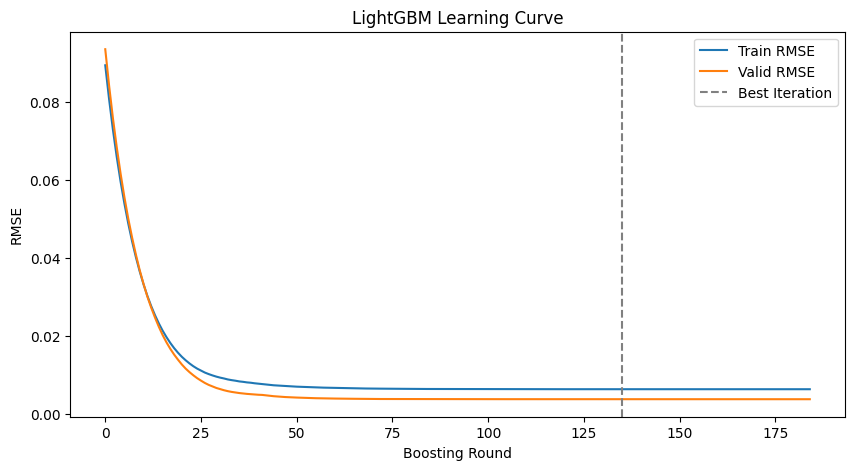

In [58]:
import matplotlib.pyplot as plt
import os

# Ergebnis-Ordner
TEMP_RESULTS_DIR = os.path.join("notebooks", "lightgbm", "temp_results")
os.makedirs(TEMP_RESULTS_DIR, exist_ok=True)  # Falls Ordner noch nicht existiert

train_rmse = eval_result['training']['rmse']
valid_rmse = eval_result['valid_1']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Valid RMSE')
plt.axvline(model.best_iteration_, color='gray', linestyle='--', label='Best Iteration')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("LightGBM Learning Curve")
plt.legend()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_learning_curve.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

# Optional anzeigen
plt.show()



In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Vorhersage auf dem finalen Testset
y_pred = model.predict(X_test)

# Metriken berechnen
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Für MAPE: sichere Division
y_test_safe = np.where(y_test == 0, 1e-10, y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

# Ausgabe
print(f"Test MAPE: {mape:.5f} %")
print(f"Test MAE: {mae:.5f}")
print(f"Test RMSE: {rmse:.5f}")


[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
Test MAPE: 2.45757 %
Test MAE: 0.00495
Test RMSE: 0.00652


In [49]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)

                  Feature  Importance
10  consumption_last_hour         394
0                hour_sin         246
7           temperature_c         228
1                hour_cos         193
9   consumption_yesterday         153
8   consumption_last_week         144
4         rolling_mean_6h         121
6               month_cos         105
5               month_sin          15
2             weekday_sin          10
3             weekday_cos           3
11          noise_feature           2


Plot gespeichert unter: notebooks/lightgbm/temp_results/lightgbm_feature_importance.png


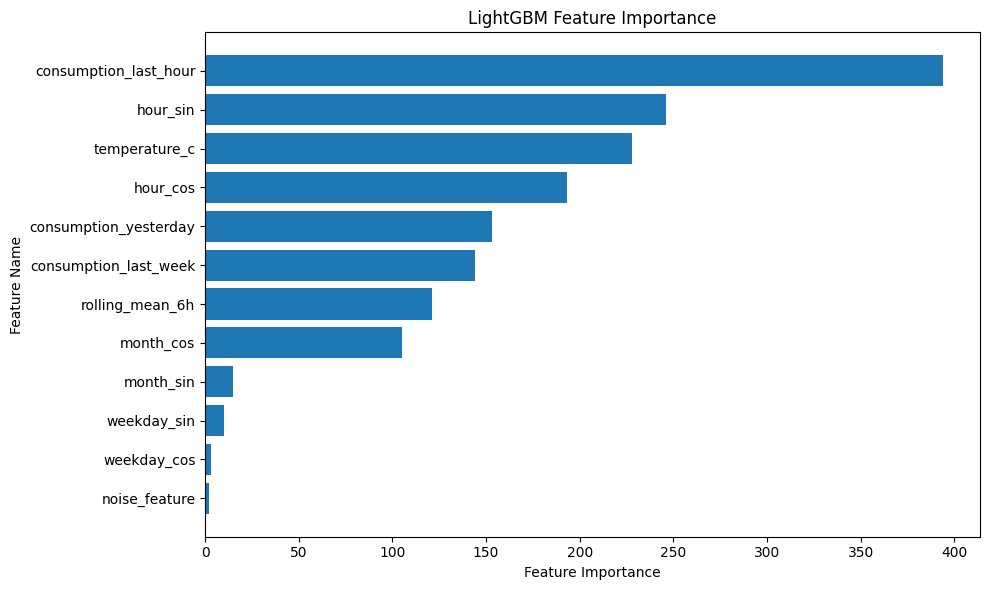

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_feature_importance.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

# Optional anzeigen
plt.show()

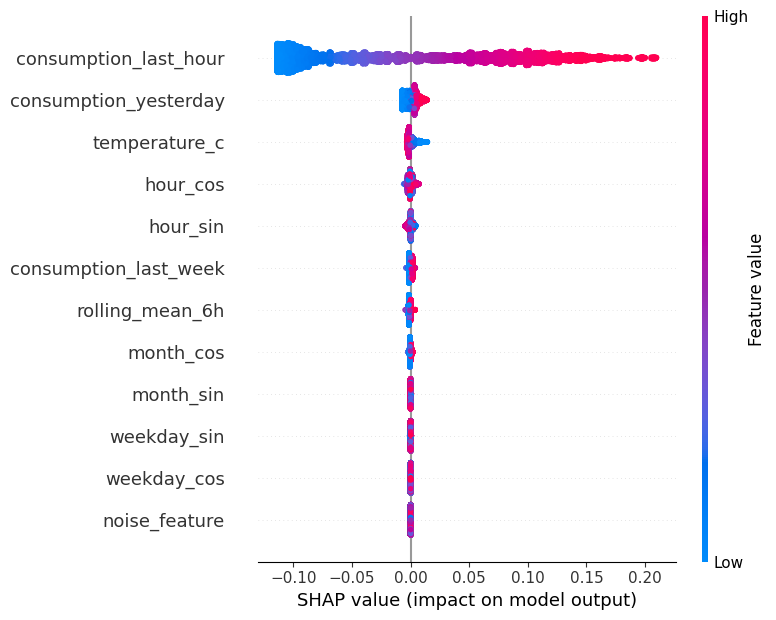

In [51]:
import shap

# SHAP initialisieren
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summary Plot
shap.summary_plot(shap_values, X_train)


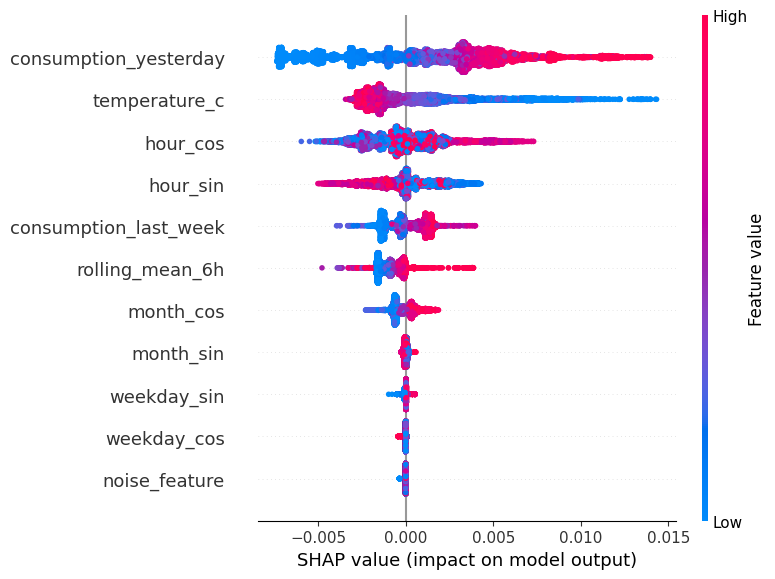

In [52]:
#plot without best feature for better overview

# Alle SHAP-Werte und Feature-Namen außer "consumption_last_hour"
feature_names = X_train.columns.tolist()
filtered_index = feature_names.index("consumption_last_hour")

# Filter SHAP values (entferne die entsprechende Spalte)
shap_values_filtered = np.delete(shap_values, filtered_index, axis=1)
X_filtered = X_train.drop(columns=["consumption_last_hour"])

# Plot neu ohne "consumption_last_hour"
shap.summary_plot(shap_values_filtered, X_filtered)


In [53]:
# DataFrame mit den Ergebnissen erstellen
results_df = pd.DataFrame({
    "True Consumption (kWh)": y_test.values,
    "Predicted Consumption (kWh)": y_pred
})

# Die ersten paar Werte ausgeben
print(results_df.head(10))

   True Consumption (kWh)  Predicted Consumption (kWh)
0                0.101072                     0.109366
1                0.098989                     0.096420
2                0.090912                     0.096347
3                0.085898                     0.088898
4                0.083908                     0.083149
5                0.084658                     0.081616
6                0.083771                     0.085533
7                0.088155                     0.083370
8                0.086961                     0.090658
9                0.094946                     0.092112


In [83]:
#create timestamps
test_dates = df1.iloc[int(len(df1)*0.8):]["date"].reset_index(drop=True)
results_df["Timestamp"] = pd.to_datetime(results_df["Timestamp"])
results_df["Timestamp"] = pd.to_datetime(test_dates.reset_index(drop=True))

Plot gespeichert unter: notebooks/lightgbm/temp_results/lightgbm_comparison_plot.png


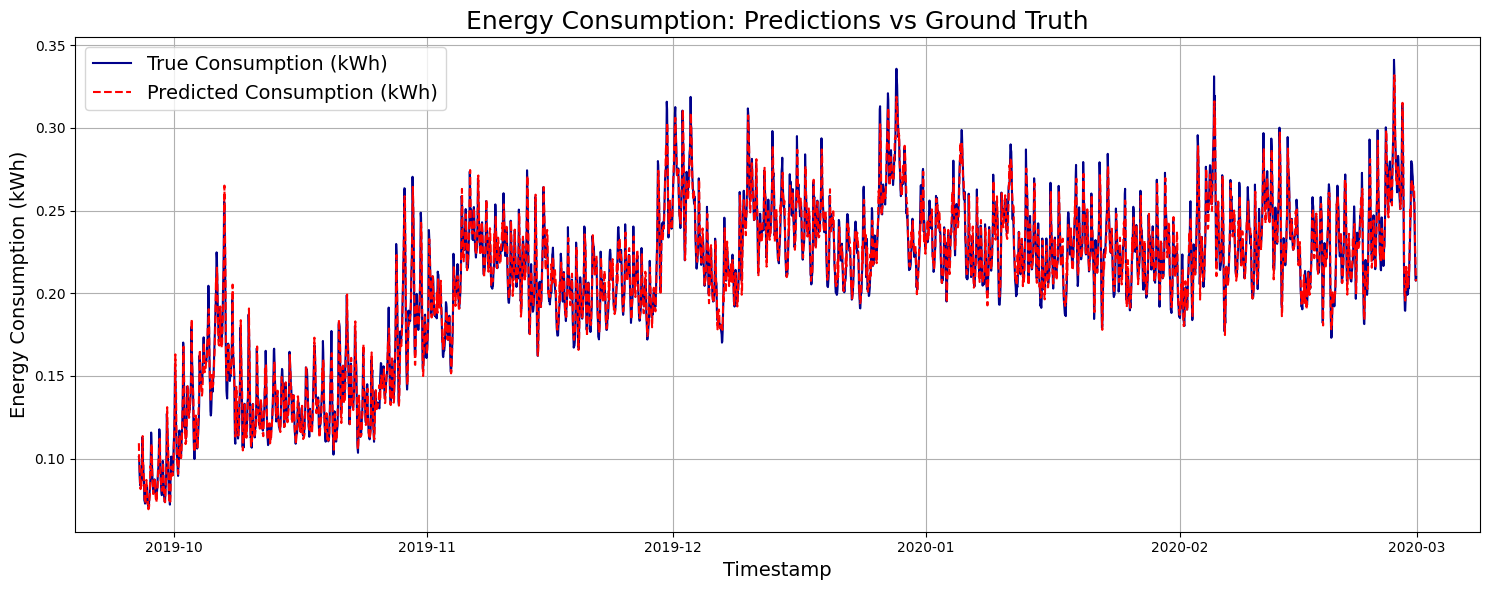

In [84]:
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(15, 6))
plt.plot(results_df["Timestamp"], results_df["True Consumption (kWh)"], label="True Consumption (kWh)", color="darkblue")
plt.plot(results_df["Timestamp"], results_df["Predicted Consumption (kWh)"], label="Predicted Consumption (kWh)", color="red", linestyle="--")

plt.title("Energy Consumption: Predictions vs Ground Truth", fontsize=18)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Energy Consumption (kWh)", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_comparison_plot.png")
plt.savefig(plot_path)
print(f"Plot gespeichert unter: {plot_path}")

plt.show()


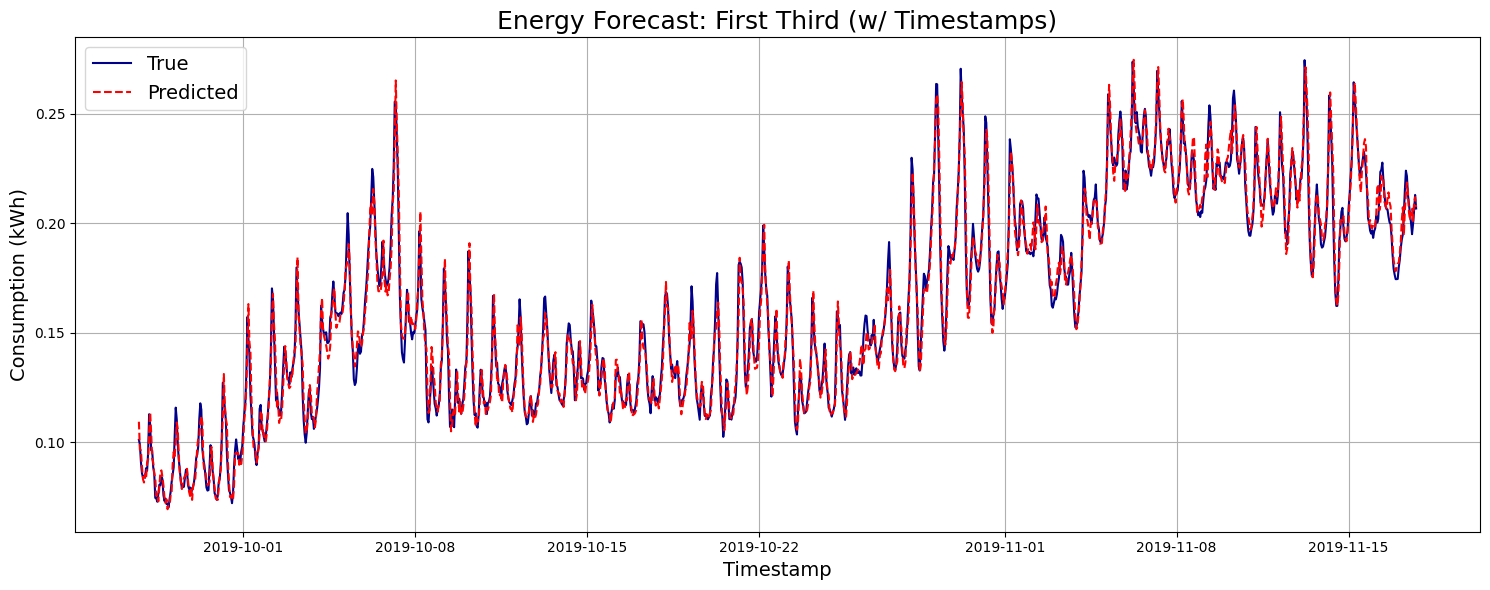

In [87]:
# Wähle nur das erste Drittel der Daten
df_subset = results_df.iloc[:len(results_df) // 3]

plt.figure(figsize=(15, 6))
plt.plot(df_subset["Timestamp"], df_subset["True Consumption (kWh)"], label="True", color="darkblue")
plt.plot(df_subset["Timestamp"], df_subset["Predicted Consumption (kWh)"], label="Predicted", color="red", linestyle="--")

plt.title("Energy Forecast: First Third (w/ Timestamps)", fontsize=18)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Consumption (kWh)", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Speichern
plot_path = os.path.join(TEMP_RESULTS_DIR, "lightgbm_prediction_with_timestamp.png")
plt.savefig(plot_path)
plt.show()



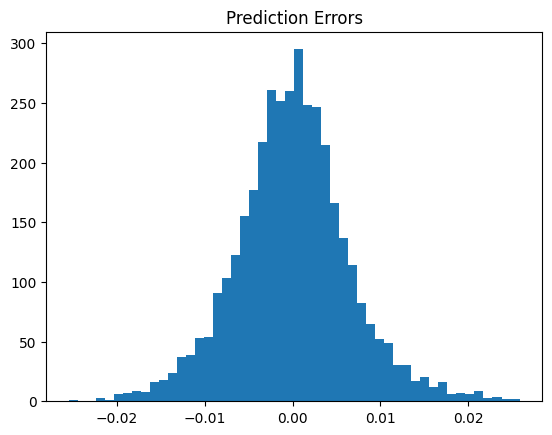

In [56]:
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.title("Prediction Errors")
plt.show()
 #normal distribution -> again seems like no overfitting

In [57]:
#again overfitting test: --> no overfitting
# Beispiel: letzte 30 Tage rausnehmen
last_month = df.tail(24 * 30)
X_last = last_month[features]
X_last["noise_feature"] = np.random.rand(len(X_last))
y_last = last_month[target]

y_pred_last = model.predict(X_last)

from sklearn.metrics import mean_absolute_error
print("MAPE auf 'neuem' Zeitraum:", np.mean(np.abs((y_last - y_pred_last) / y_last)) * 100)


[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
MAPE auf 'neuem' Zeitraum: 2.2238372987908157
